In [1]:
# check that we can add a starting sequence to observations

from rubin_scheduler.scheduler.model_observatory import ModelObservatory
from rubin_scheduler.scheduler.surveys import BaseSurvey, FieldSurvey
from rubin_scheduler.scheduler.utils import ObservationArray, SkyAreaGenerator, Footprint
from rubin_scheduler.scheduler.schedulers import CoreScheduler, SimpleFilterSched
from rubin_scheduler.scheduler import sim_runner
from rubin_scheduler.scheduler.detailers import StartFieldSequenceDetailer
from rubin_scheduler.utils import (_approx_ra_dec2_alt_az, _approx_altaz2pa, 
                                   rotation_converter, SysEngVals, _approx_alt_az2_ra_dec,
                                  _ra_dec2_hpid)
import rubin_scheduler.scheduler.basis_functions as basis_functions

import numpy as np
import healpy as hp
import matplotlib.pylab as plt
%matplotlib inline

import pandas as pd


In [2]:
# load up a model observatory
nside = 32
mo = ModelObservatory(downtimes="ideal", cloud_data="ideal", nside=nside)

In [3]:
# basic basis functions for a FieldSurvey

bfs = []
bfs.append(basis_functions.AltAzShadowMaskBasisFunction(
            nside=nside,
            min_alt=20.0,
            max_alt=83.0,
            shadow_minutes=2.0,
        ))

bfs.append(basis_functions.SlewtimeBasisFunction(filtername="r", nside=nside))

In [4]:
# Have three positions on the sky
# XXX--note these get converted to radians below. ObservationArray is
# a mostly internally passed object, so it's values are all radians
ras = [0, 120, 240]
decs = [-20, -21, -22]

surveys = []
for ra,dec in zip(ras, decs):
    # The starting observation sequence
    starting_obs_list = []
    for filtername in ["r", "i", "z"]:
        starting_obs = ObservationArray(n=1)
        starting_obs["filter"] = filtername
        starting_obs["RA"] = np.radians(ra)
        starting_obs["dec"] = np.radians(dec)
        starting_obs_list.append(starting_obs)
    # Detailer that will add the starting sequence
    # if criteria is met.
    detailer = StartFieldSequenceDetailer(ra=ra, dec=dec, sequence_obs_list=starting_obs_list)

    
    surveys.append(FieldSurvey(bfs, ra, dec, detailers=[detailer], sequence="r",
                              target_name='Field_%i' % ra, scheduler_note='boogers'))


In [5]:
scheduler = CoreScheduler(surveys, nside=nside)

In [6]:
mo, scheduler, observations = sim_runner(mo, scheduler, sim_duration=3.0, verbose=True)

/Users/yoachim/git_repos/rubin_scheduler/rubin_scheduler/scheduler/schedulers/core_scheduler.py:292: RuntimeWarning: All-NaN axis encountered
  rewards[i] = np.nanmax(survey.calc_reward_function(self.conditions))
/Users/yoachim/git_repos/rubin_scheduler/rubin_scheduler/scheduler/model_observatory/kinem_model.py:755: RuntimeWarning: invalid value encountered in divide
  (observation["exptime"] / observation["nexp"] + self.readtime * (observation["nexp"] - 1))
/Users/yoachim/git_repos/rubin_scheduler/rubin_scheduler/scheduler/model_observatory/kinem_model.py:743: RuntimeWarning: invalid value encountered in divide
  delta_t = observation["exptime"] / observation["nexp"]
/Users/yoachim/git_repos/rubin_scheduler/rubin_scheduler/scheduler/model_observatory/model_observatory.py:523: RuntimeWarning: invalid value encountered in divide
  observation["exptime"] / observation["nexp"],


progress = 1.39%

/Users/yoachim/git_repos/rubin_scheduler/rubin_scheduler/scheduler/schedulers/core_scheduler.py:294: RuntimeWarning: All-NaN slice encountered
  if np.nanmax(rewards) > -np.inf:
/Users/yoachim/git_repos/rubin_scheduler/rubin_scheduler/scheduler/schedulers/core_scheduler.py:297: RuntimeWarning: All-NaN slice encountered
  if (np.nanmax(rewards) == -np.inf) | (np.isnan(np.nanmax(rewards))):
Failed to fill queue at time [60980.08053806]


progress = 3.04%

/Users/yoachim/git_repos/rubin_scheduler/rubin_scheduler/scheduler/sim_runner.py:157: UserWarning: No observation. Step into the future and trying again.
  warnings.warn("No observation. Step into the future and trying again.")


progress = 33.35%

/Users/yoachim/git_repos/rubin_scheduler/rubin_scheduler/skybrightness_pre/sky_model_pre.py:352: UserWarning: Requested MJD between sunrise and sunset, returning closest maps
  warnings.warn("Requested MJD between sunrise and sunset, returning closest maps")


progress = 34.75%

Failed to fill queue at time [60981.08117745]


progress = 100.07%Skipped 2 observations
Flushed 0 observations from queue for being stale
Completed 2536 observations
ran in 0 min = 0.0 hours


In [7]:
np.unique(observations["science_program"])

ObservationArray(['', 'None'], dtype='<U40')

In [8]:
np.unique(observations["scheduler_note"])

ObservationArray(['boogers', 'starting_sequence'], dtype='<U40')

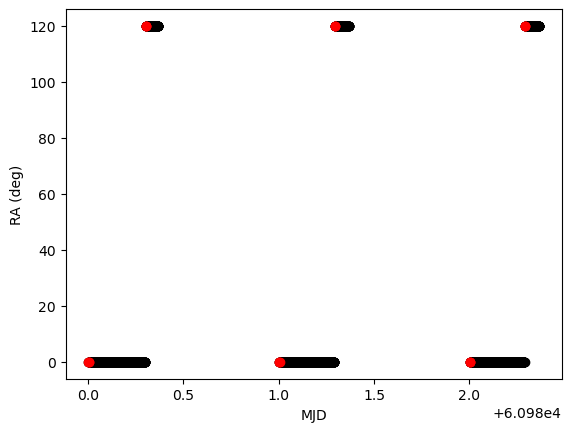

In [9]:
plt.plot(observations["mjd"], np.degrees(observations["RA"]), 'ko')
plt.xlabel("MJD")
plt.ylabel("RA (deg)")

ss = np.where(observations["scheduler_note"] == 'starting_sequence')
plt.plot(observations["mjd"][ss], np.degrees(observations["RA"][ss]), 'ro')



In [10]:
observations["filter"][ss]

ObservationArray(['r', 'i', 'z', 'r', 'i', 'z', 'r', 'i', 'z', 'r', 'i',
                  'z', 'r', 'i', 'z', 'r', 'i', 'z'], dtype='<U40')